In [1]:
# Convert to python script, remember to delete/comment the next line in the actual file
# ! jupyter nbconvert --to python imageSegmentationWithBackground.ipynb --output testSamples17-7.py

### # Imports

In [2]:
# Image reading and file handling 
import pandas as pd
import SimpleITK as sitk 
import os 
import shutil

# Image agumentaitons
import numpy as np
import cv2

# import scipy

# Information saving
import pickle

# Train test set spliting
from sklearn.model_selection import train_test_split

# Dataset building
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import random
from sklearn.model_selection import StratifiedKFold

# Model building
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

# Evaluation metrics and Plotting
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# ! pip freeze > requirements.txt
# ! pip uninstall -y -r requirements.txt

## Download necessary packages 
# ! pip install matplotlib opencv-python scipy simpleitk pandas openpyxl scikit-learn nbconvert
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

## For 3D image classification
# ! pip install foundation-cancer-image-biomarker -qq
# ! pip install foundation-cancer-image-biomarker
# ! pip install torchio

## Check python version and packages
# ! python --version
# ! pip freeze > research.txt

## Get the data from the .xsxl file

In [4]:
columns = ['TAPS_CaseIDs_PreNAT','RECIST_PostNAT', 'Slice_Thickness']
data = pd.read_excel('PDAC-Response_working.xlsx', header=None,names = columns)
data.drop(0, inplace=True) # Remove the header row
data=data.sort_values(by=['TAPS_CaseIDs_PreNAT'])

# # Get the entire datasheet
cases = list(data['TAPS_CaseIDs_PreNAT'])
recistCriteria = list(data['RECIST_PostNAT'])

## Perform preprocessing on multiple images


In [5]:
def window_image_to_adbomen(image, window_center, window_width):
    
    img_max = window_center + int(window_width / 2)
    img_min = window_center - int(window_width / 2)
    return np.clip(image, img_min, img_max)

def centerXYOfImage(overlay_mask, segment_mask, segmentedSlices, padding=10, scaledBoxes = None):
    """ 
    Centers the X and Y of the image to crop the image. segmentedSlices is given as an array of z-value slices because the same approach to x_indicies and y_indicies does not work on overlay_segment (works for x and y though)
    """
    _, x_indices, y_indices = np.where(segment_mask == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    print('min and max values') ##
    print(min_x, max_x) ##
    print(min_y, max_y) ##

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2


    print('Centers') ##
    print(center_x, center_y) ##

    if scaledBoxes == None: # Define width and height in regards of the single image
        width = abs(max_x - min_x) // 2
        height = abs(max_y - min_y) // 2
    else:
        width = scaledBoxes[0]//2
        height = scaledBoxes[1]//2

    # Get the dimensions of the cropped image
    start_x = max(0, center_x - width - padding)
    end_x = min(segment_mask.shape[1], center_x + width + padding)
    start_y = max(0, center_y - height - padding)
    end_y = min(segment_mask.shape[2], center_y + height + padding)

    print('start and ends') ##
    print(start_x, end_x) ##
    print(start_y, end_y) ##

    # segmentedSlices = np.sort(np.array(segmentedSlices))
    return overlay_mask[np.array(segmentedSlices), start_x:end_x, start_y:end_y]

In [6]:
# postSegmentHeader = sitk.ReadImage('Pre-treatment-only-pres/CASE585/CASE585_BASE_PRT_TUM_HK.seg.nrrd')
# postSegment = sitk.GetArrayFromImage(postSegmentHeader)
# print(postSegmentHeader.GetSize())
# print(postSegmentHeader.GetDirection())
# space_direction = postSegmentHeader.GetDirection()

# if space_direction[8] == 0:
#     postSegment = np.flip(postSegment, axis=0)

# def display_axial_slice(postSegment, slice_index):
#     axial_slice = postSegment[slice_index, :, :]
#     plt.imshow(axial_slice, cmap='gray')
#     plt.title(f'Axial Slice {slice_index}')
#     plt.axis('off')
#     plt.show()


# segmentedSlices = [] 
# print(postSegment.shape[0])
# for index in range(postSegment.shape[0]):
#     if len(np.unique(postSegment[index,:,:])) > 1:
#         segmentedSlices.append(index)
# print(segmentedSlices)

# axial_slice_index = postSegment.shape[0] // 2
# for slice in segmentedSlices:
#     display_axial_slice(postSegment, slice)

In [7]:
def convertNdArrayToCV2Image(image, resolution = (64,64)):
    """ Converts a numpy array to a cv2 image """

    if resolution == None:
        resolution = (64,64)
    image = np.array(image, dtype=np.uint8)
    image = cv2.resize(image, resolution)
    return image

def makeAlign(image1,image2):
    image1.SetDirection(image2.GetDirection())
    image1.SetOrigin(image2.GetOrigin())
    image1.SetSpacing(image2.GetSpacing())
    return image1, image2

def isAligned(image1, image2):
    return image1.GetDirection() == image2.GetDirection() and image1.GetOrigin() == image2.GetOrigin() and image1.GetSpacing() == image2.GetSpacing()   

def resampleSizes(wholeHeader, segmentHeader):
    """ 
    Resamples the sitk image to have the same size based on the one with the largest size.
    """
    if wholeHeader.GetSize()[-1] >= segmentHeader.GetSize()[-1]:
        imageLarge = wholeHeader
        imageSmall = segmentHeader
        wholeThenSegmentOrder = True
    else:
        imageLarge = segmentHeader
        imageSmall = wholeHeader 
        wholeThenSegmentOrder = False

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(imageLarge)  
    resample.SetInterpolator(sitk.sitkLinear)  # Choose the interpolation method (sitkLinear, sitkNearestNeighbor, etc.)
    resample.SetDefaultPixelValue(0)  # Set default pixel value for areas outside the original image

    imageSmall = resample.Execute(imageSmall)

    print(f'imageLarge: {imageLarge.GetSize()}')
    print(f'imageSmall: {imageSmall.GetSize()}')
    

    if wholeThenSegmentOrder:
        return imageLarge, imageSmall # whole, then segment
    else:
        return imageSmall, imageLarge # segment, then whole

In [8]:
def twoImageAlignProceess(wholeHeader,segmentHeader,verbose):    

    error = False
    # Check if the images are aligned
    wholeHeader, segmentHeader = makeAlign(wholeHeader, segmentHeader)
    imagesAreAligned = isAligned(wholeHeader, segmentHeader)
    print(f'Are the two images aligned now?: {imagesAreAligned}' if verbose==2 else '',end='')

    if not imagesAreAligned:
        error = True
        return None, None, True
    
    # Set the spacing of the image to 1x1x1mm voxel spacing
    wholeHeader.SetSpacing([1,1,1])
    segmentHeader.SetSpacing([1,1,1])
    imagesSpacingAligned = wholeHeader.GetSpacing() == segmentHeader.GetSpacing() 
    print(f'Are the two images aligned in terms of spacing?: {imagesSpacingAligned}' if verbose==2 else '',end='')

    if not imagesSpacingAligned:
        error = True
        return None, None, True
    

    imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
    print(f'Are the two images aligned in terms of size?: {imagesSizeAligned}' if verbose==2 else '',end='')

    if not imagesSizeAligned:
        wholeHeader, segmentHeader = resampleSizes(wholeHeader, segmentHeader)
        print(f'whole size: {wholeHeader.GetSize()}')
        print(f'segment size: {segmentHeader.GetSize()}')
        imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
        print(f'Are the two images aligned in terms of size now?: {imagesSizeAligned}' if verbose==2 else '',end='')
        if not imagesSizeAligned:
            error = True
            return None, None, True

    
    return wholeHeader, segmentHeader, False

    

In [125]:
def displayCroppedSegmentations(croppedSegment):
    print(f'CroppedSegment shape: {croppedSegment.shape}')
    # Display the segmented image slices 

    columnLen = 10
    rowLen = max(2,croppedSegment.shape[0] // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    
    rowIdx = 0
    for idx in range(croppedSegment.shape[0]):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1        
        axis[rowIdx][idx%columnLen].imshow(croppedSegment[idx,:,:] , cmap="gray", vmin = 40-(350)/2, vmax=40+(350)/2)
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    plt.show()


def displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment):
    # Display the segmented image slices 
    columnLen = 10
    rowLen = max(2,len(segmentedSlices) // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    rowIdx = 0
    for idx in range(len(segmentedSlices)):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(augmented_whole[segmentedSlices[idx],:,:], cmap="gray")
        axis[rowIdx][idx%columnLen].imshow(augmented_segment[segmentedSlices[idx],:,:], cmap="Blues", alpha=0.75)
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    plt.show()

In [133]:
def getLargestSlice(croppedSegment):
    """
    Finds the index with the largest slice in the croppedSegment and returns the index as well as the sorted number of slices each index has
    """
    max = 0
    maxIndex = 0
    
    indices = []
    sliceTotals = []
    for idx in range(croppedSegment.shape[0]):
        unique, counts = np.unique(croppedSegment[idx,:,:], return_counts=True)
        values = dict(zip(unique, counts))
        sliceTotal = 0
        for value,count in values.items():
            sliceTotal += count if value > 0 else 0 
        

        indices.append(idx)
        sliceTotals.append(sliceTotal)
        
        if sliceTotal > max: 
            max = sliceTotal
            maxIndex = idx 

    values = dict(zip(sliceTotals,indices))
    values = dict(sorted(values.items())) # Sort the values by number of slices

    return maxIndex, values

def updateSlices(croppedSegment, desiredNumberOfSlices=1):
    """
    Updates the number of slices to the number of slices given. 
    If the numberOfSlices > the number of slices in the croppedSegment, it will duplicate the slices of the largest slices 
    If the numberOfSlices < the number of slices in the croppedSegment, it will remove the slices with the least amount of information 
    If the numberOfSlices == the number of slices in the croppedSegment, it will do nothing     
    """
    if croppedSegment.shape[0] == desiredNumberOfSlices:
        return croppedSegment
    elif croppedSegment.shape[0] < desiredNumberOfSlices: # Duplicate slices from the largest slice

        # Specifications of croppedSegment
        original = np.copy(croppedSegment)
        largestSliceIndex, _ = getLargestSlice(croppedSegment)
        maxUpperBound = croppedSegment.shape[0] -1
        minLowerBound = 0
        
        # Specification of the values to duplicate
        numToDuplication = desiredNumberOfSlices - croppedSegment.shape[0] 
        ends = numToDuplication//2
        lowerRemainder = abs(largestSliceIndex - ends) if (largestSliceIndex - ends) < minLowerBound else 0   
        upperRemainder = abs(maxUpperBound - (largestSliceIndex + ends)) if largestSliceIndex + ends > maxUpperBound else 0 

        #Printing of the of the specifications
        print(f'LargestSegmentIdx = {largestSliceIndex}\nNumber of slices to duplicate: {numToDuplication}\n Ends: {ends}, \nlowerRemainder: {lowerRemainder},\n upperRemainder: {upperRemainder}')
        
        #Making of the range to center the slices to duplicate
        duplicationRange = list(range( largestSliceIndex - ends - upperRemainder + lowerRemainder , largestSliceIndex + ends + lowerRemainder - upperRemainder))

        print('preAdd',duplicationRange)
        #Edge case where we only need 1 extra slice
        if len(duplicationRange) == 0:
            duplicationRange = [largestSliceIndex]

        # Fixes the slices if we are off by 1
        if len(duplicationRange)+croppedSegment.shape[0] == desiredNumberOfSlices: 
            pass 
        else:
            # Add to the right side if the left will be out of bounds
            if duplicationRange[-1] -1 < minLowerBound:
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
            # Add to the left side if the right will be out of bounds
            elif duplicationRange[-1] +1 > maxUpperBound:
                duplicationRange = [duplicationRange[0] - 1] + duplicationRange
            else: #Default, add to the right side
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
                
        print(f'CroppedSlices={list(range(0,croppedSegment.shape[0]))}\nSlices: {duplicationRange}')
        print(len(duplicationRange)+croppedSegment.shape[0])
        assert(len(duplicationRange)+croppedSegment.shape[0]== desiredNumberOfSlices) #Ensure that the desired number of slices is met

        #Insert the values
        croppedSegment = np.insert(croppedSegment, duplicationRange, original[:,:,duplicationRange], axis=0)
            
        print('greater than')
        return croppedSegment
    else:
        # Specifications of croppedSegment
        _, sliceValues = getLargestSlice(croppedSegment)
        numberOfSlicesToRemove =  croppedSegment.shape[0] - desiredNumberOfSlices 
        print(croppedSegment.shape)
        # Remove the slices with the least amount of information
        print(list(sliceValues.values()))
        print(list(sliceValues.values())[:numberOfSlicesToRemove])
        
        croppedSegment = np.delete(croppedSegment,list(sliceValues.values())[:numberOfSlicesToRemove], axis=0)
        print(croppedSegment.shape, f'Removed this many slices: {numberOfSlicesToRemove}')
        print('Less than')
        return croppedSegment

In [119]:
def preprocess(wholeHeader, segmentHeader, verbose=0, useBackground = False, scaledBoxes = None, desiredSliceNumber=1):
    """
    Preprocesses the wholeHeader and segmentHeader sitk images to be ready for augmentation 
    Verbose = 0: No output
    Verbose = 1: Only the CT scans slices and the array of slices it uses
    Verbose = 2: Everything
    Verbose = 3: Show the segment mask on top of the whole CT scan

    Returns: a np array windowed whole image, a np array cropped segment image to 64x64x[] resolution, and boolean error flag.
    """
    error = False # Error flag to check if there was an error in the preprocessing

    # Align the two images 
    wholeHeader, segmentHeader, error = twoImageAlignProceess(wholeHeader, segmentHeader, verbose) 
    if error:
        return None, None, error
    
    # Convert the images into numpy arrays for further processing, take the transpose as the format is z,y,x
    whole = sitk.GetArrayFromImage(wholeHeader)
    segment = sitk.GetArrayFromImage(segmentHeader)

    print(f'Spacing of whole:{whole.shape}' if verbose==2 else '',end='')
    print(f'Spacing of segment:{segment.shape}' if verbose==2 else '',end='')
    
    # Windowing parameters for the abdomen
    window_center = 40
    window_width = 350
    
    # Window and resample the whole image
    augmented_whole = window_image_to_adbomen(whole, window_center, window_width)

    # Get the slice indices where the segment is present in 
    augmented_segment = segment
    segmentedSlices = [] 
    for index in range(augmented_segment.shape[0]):
        if len(np.unique(augmented_segment[index,:,:])) > 1:
            segmentedSlices.append(index)

    print(f'Segment slice indices:{segmentedSlices}' if verbose==2 else '',end='')


    #Segment the whole image with the segment mask
    overlay_segment = augmented_whole * augmented_segment    

    # overlay_segment = np.where(augmented_segment!=0, augmented_segment- augmented_whole, 0)
    # overlay_segment = np.ma.masked_where(augmented_segment==0, augmented_segment*augmented_whole, 1)
 
    if useBackground:
        croppedSegment = centerXYOfImage(augmented_whole,augmented_segment,segmentedSlices, padding=5, scaledBoxes = scaledBoxes) # Crop the image to the center of the segmented region     
    else:
        croppedSegment = centerXYOfImage(overlay_segment,augmented_segment,segmentedSlices, padding=5, scaledBoxes = scaledBoxes) # Crop the image to the center of the segmented region     

    # Resize image if no scaling is given already
    if scaledBoxes==None:
        croppedSegment = convertNdArrayToCV2Image(croppedSegment)

    # croppedSegment = updateSlices(croppedSegment,desiredSliceNumber)

    #Display the results of preprocessing
    if verbose==1 or verbose==2:
        displayCroppedSegmentations(croppedSegment)
    elif verbose==3:
        displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment)
    
    return whole, croppedSegment, error

In [13]:
def getSegmentBoxDimensions(preSegmentHeader):
    segment = sitk.GetArrayFromImage(preSegmentHeader)

    _, x_indices, y_indices = np.where(segment == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    width = abs(max_x - min_x)
    height = abs(max_y - min_y)
    
    return width, height

allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
                'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
                'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
                'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']

onlySeeTheseCases = allFolders
baseFilepath = 'Pre-treatment-only-pres/'


largestWidth, largestHeight = 0,0
# Find the largest box that fits all slices
for folder in os.listdir(baseFilepath):
    # Skip cases that are not in the excel sheet
    if folder not in cases:
        continue
    # Exclude to cases that we haven't seen yet
    if folder not in onlySeeTheseCases:
        continue 
    count = 0
    for file in os.listdir(os.path.join(baseFilepath,folder)):
        if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
            preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
        else: 
            continue

        print(folder)
        width, height = getSegmentBoxDimensions(preSegmentHeader)
        print(f'Width= {width}, Height= {height} (Largest? {width > largestWidth} and {height > largestHeight})')
        print('=============================')

        # Get the largest width and height
        if width > largestWidth:
            largestWidth = width
        if height > largestHeight:  
            largestHeight = height


dimensions = (largestWidth,largestHeight)
print(dimensions)

CASE244
Width= 37, Height= 37 (Largest? True and True)
CASE246
Width= 47, Height= 56 (Largest? True and True)
CASE247
Width= 53, Height= 42 (Largest? True and False)
CASE251
Width= 28, Height= 43 (Largest? False and False)
CASE254
Width= 32, Height= 32 (Largest? False and False)
CASE256
Width= 53, Height= 67 (Largest? False and True)
CASE263
Width= 49, Height= 56 (Largest? False and False)
CASE264
Width= 25, Height= 34 (Largest? False and False)
CASE265
Width= 36, Height= 58 (Largest? False and False)
CASE270
Width= 62, Height= 77 (Largest? True and True)
CASE274
Width= 41, Height= 46 (Largest? False and False)
CASE467
Width= 66, Height= 69 (Largest? True and False)
CASE468
Width= 27, Height= 35 (Largest? False and False)
CASE471
Width= 32, Height= 31 (Largest? False and False)
CASE472
Width= 23, Height= 27 (Largest? False and False)
CASE476
Width= 57, Height= 56 (Largest? False and False)
CASE479
Width= 45, Height= 49 (Largest? False and False)
CASE480
Width= 31, Height= 45 (Largest? 

CASE244 All files read:
Are the two images aligned now?: TrueAre the two images aligned in terms of spacing?: TrueAre the two images aligned in terms of size?: TrueSpacing of whole:(135, 512, 512)Spacing of segment:(135, 512, 512)Segment slice indices:[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]min and max values
235 272
226 263
Centers
253 244
start and ends
207 299
185 303
CroppedSegment shape: (17, 92, 118)


KeyboardInterrupt: 

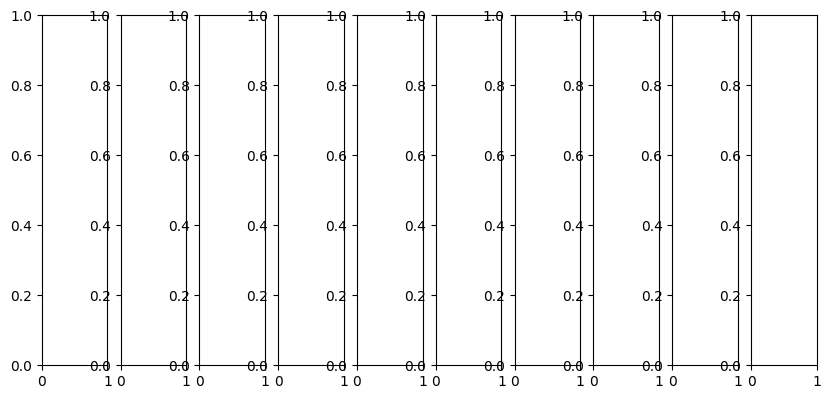

In [135]:
# allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
#                 'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
#                 'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
#                 'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']

onlySeeTheseCases = allFolders #['CASE585','CASE587']
desiredSliceNumber=13
croppedSegmentsList = []

# Get all cropped segments
for folder in os.listdir(baseFilepath):
    # Skip cases that are not in the excel sheet
    if folder not in cases:
        continue
    # Exclude to cases that we haven't seen yet
    if folder not in onlySeeTheseCases:
        continue 
    count = 0
    preSegmentHeader = None
    wholeHeader = None
    for file in os.listdir(os.path.join(baseFilepath,folder)):
            
        if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
            # segment, segmentHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
            preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
        elif file.endswith('CT.nrrd'): # whole ct scan
            wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
    
    print('==============================================================')
    print(folder, 'All files read:')
      
    whole, croppedSegment,error = preprocess(wholeHeader, preSegmentHeader, verbose=2, useBackground=False, scaledBoxes=dimensions, desiredSliceNumber=desiredSliceNumber) 
    if error:
        print('Error in preprocessing')
        # continue
    print(np.unique(croppedSegment[0,:,:]))
    
    #Update the number of slices so that it reaches desiredSliceNumber
    updatedCroppedSegment = updateSlices(croppedSegment,desiredSliceNumber)
    
    # Uncomment these if using single slice
    # largestSlice,_ = getLargestSlice(croppedSegment)
    # updatedCroppedSegment = croppedSegment[:,:,largestSlice]

    croppedSegmentsList.append(updatedCroppedSegment)
    


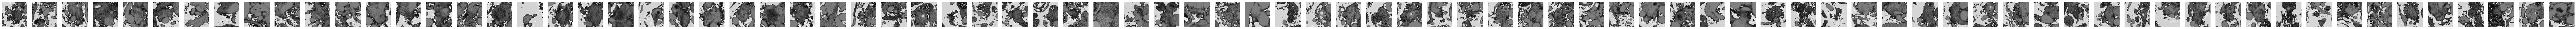

In [ ]:
figure,axis = plt.subplots(1,len(croppedSegmentsList),figsize=(200,100))
for idx in range(len(croppedSegmentsList)):        
    axis[idx].imshow(croppedSegmentsList[idx], cmap="gray")
    axis[idx].axis('off')
plt.savefig('padding10.png')
# plt.show()

# SPLITING THE DATA INTO TRAIN AND TEST SETS

In [ ]:
# xTrain, xTest, yTrain, yTest = train_test_split(croppedSegmentsList, recistCriteria,test_size=0.15, random_state=42)

# print(f'xTrain: {len(xTrain)}')
# print(f'yTrain: {len(yTrain)}')
# print(f'xTest: {len(xTest)}')
# print(f'yTest: {len(yTest)}')


# # Convert the recist criteria to 0,1,2
# yTrain = [x-1 for x in yTrain]
# yTest = [x-1 for x in yTest]

# # VIEWING THE CATEGORIZATION SPLITS OF THE TRAIN AND TEST SET

# # Add in 2 more progessive disease (1) into the test set
# for i in range(2):
#     idx = yTrain.index(0)
#     xTest.append(xTrain[idx])
#     yTest.append(yTrain[idx])
#     xTrain.pop(idx)
#     yTrain.pop(idx)

# #count the categorization splits of the train and test set
# trainRecistSplit = {y: yTrain.count(y) for y in yTrain}
# testRecistSplit = {y: yTest.count(y) for y in yTest}

# # Format the splits nicely into an ordered dictionary
# myKeys = list(trainRecistSplit.keys())
# myKeys.sort()
# trainRecistSplitDisplay = {i: trainRecistSplit[i] for i in myKeys}
# myKeys = list(testRecistSplit.keys())
# myKeys.sort()
# testRecistSplitDisplay = {i: testRecistSplit[i] for i in myKeys}

# print(f'train recist category split: {trainRecistSplitDisplay}')
# print(f'test recist category split: {testRecistSplitDisplay}')

# ## Working with Numpy arrays
# xTrain = np.array(xTrain) 
# xTest = np.array(xTest)
# yTrain = np.array(yTrain)
# yTest = np.array(yTest)
# xTrain =  np.expand_dims(xTrain,axis=-1)
# xTest =  np.expand_dims(xTest,axis=-1)

# print(xTrain.shape)
# print(yTrain.shape)
# print(xTest.shape)
# print(yTest.shape)


In [ ]:
# For 2D images:
# ## Working with pytorch tensors
class TorchDataset(Dataset):
    def __init__(self, image, classifications, transform=None):
        self.data = image
        temp = []
        for classification in classifications:
            convert = torch.tensor(classification, dtype=torch.int64) # casting to long
            convert = convert.type(torch.LongTensor)
            temp.append(convert)
            
        self.classification = temp
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        
        # Normalize the images pre augmentation
        image = (image - np.mean(image)) / np.std(image)
        
        # Apply augmentations if there are any
        if self.transform:
            image = self.transform(image)
        # Normalize the images post augmentation
        image = (image - torch.mean(image)) / torch.std(image)
        label = self.classification[idx]
        return image, label
    

def convertDataToLoaders(xTrain, yTrain, xVal, yVal, xTest, yTest, training_data_transforms = None, batchSize=8):
    ## Sample the data with 75% of the training set 
    # TrainBalancedSampler = WeightedRandomSampler(weightsForClasses, len(yTrain)//2+len(yTest)//4)

    if training_data_transforms==None:
        # Define a default data augmentation transforms
        training_data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(50),
            transforms.ToTensor()
        ]) 
    
    # Testing data tranfrom, should be just the plain images
    testing_data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ]) 


    # Convert the testing sets to data loaders
    trainingData = TorchDataset(xTrain, yTrain, transform=training_data_transforms)
    trainingData = DataLoader(trainingData, batch_size=batchSize, shuffle=False)#, sampler= TrainBalancedSampler)

    validationData = TorchDataset(xVal, yVal, transform=testing_data_transforms)
    validationData = DataLoader(validationData, batch_size=batchSize, shuffle=False)

    testingData = TorchDataset(xTest, yTest, transform=testing_data_transforms)
    testingData = DataLoader(testingData, batch_size=batchSize, shuffle=False)

    return trainingData, validationData, testingData, training_data_transforms



In [ ]:
# # For 3D images:

# import torchio

# # ## Working with pytorch tensors
# class TorchDataset(Dataset):
#     def __init__(self, images, classifications, transform=None):
#         self.data = images
#         temp = []
#         for classification in classifications:
#             convert = torch.tensor(classification, dtype=torch.int64) # casting to long
#             convert = convert.type(torch.LongTensor)
#             temp.append(convert)
            
#         self.classification = temp
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         images = self.data[idx]
#         # Normalize the images
#         images = (images - np.min(images)) / (np.max(images) - np.min(images))


#         images = torch.from_numpy(images)
#         images = torch.FloatTensor(images)

#         # images = torch.from_numpy(images)
#         print(type(images))
        

#         label = self.classification[idx]
#         # Convert sample to a tensor
#         # sample = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1)  # Change shape to (C, H, W)

#         if self.transform:
#             images = self.transform(images)
        
#         return images, label
    

# # Set the random seed for reproducibility
# random.seed(0)
# torch.manual_seed(0) 

# ## Sample the data with 75% of the training set 
# # TrainBalancedSampler = WeightedRandomSampler(weightsForClasses, len(yTrain)//2+len(yTest)//4)

# # Define data augmentation transforms
# training_data_transforms = torchio.Compose([
#     torchio.RandomFlip(axes=('Left','Right'), flip_probability=RandomVerticalFlipProbablility),
#     torchio.RandomFlip(axes=('Anterior','Posterior'), flip_probability=RandomHorizontalFlipProbablility),
#     torchio.RandomNoise(std=(0, 0.1)),
#     torchio.RandomBlur(std=(0, 1))
# ]) 
# # testing_data_transforms = transforms.Compose([
# #     transforms.ToPILImage(),
# #     transforms.ToTensor()
# # ]) 


# # Convert the testing sets to data loaders
# trainingData = TorchDataset(xTrain, yTrain, transform=training_data_transforms)

# trainingData = DataLoader(trainingData, batch_size=BATCHSIZE, shuffle=False)#, sampler= TrainBalancedSampler)

# testingData = TorchDataset(xTest, yTest, transform=None)# testing_data_transforms)
# testingData = DataLoader(testingData, batch_size=BATCHSIZE, shuffle=False)

### Define Model and training

In [ ]:
class ResNet50ClassificaitonModel(torch.nn.Module):
    def __init__(self):
        super(ResNet50ClassificaitonModel, self).__init__()

        #Resnet50 as first layer
        self.resNet50 = models.resnet50(pretrained=True)

        # Modify the first convolutional layer to accept single-channel input
        self.resNet50.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=True)

        # Freeze all layers of the resNet
        for param in self.resNet50.parameters():
            param.requires_grad = False
        
        
        # Hidden layers with batchnorms
        self.batchNormalization0 = nn.BatchNorm1d(self.resNet50.fc.out_features)
        self.hiddenLayer1 = nn.Linear(self.resNet50.fc.out_features, 528)
        self.batchNormalization1 = nn.BatchNorm1d(528)
        self.hiddenLayer2 = nn.Linear(528, 128)
        self.batchNormalization2 = nn.BatchNorm1d(128)
        self.hiddenLayer3 = nn.Linear(128, 64)
        self.batchNormalization3 = nn.BatchNorm1d(64)

        # Output layer
        self.outputLayer = nn.Linear(64, 3)
        self.softmax = nn.Softmax()

        #Other layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        # Into ResNet
        x = self.resNet50(x)
        x = self.batchNormalization0(x)
        x = self.relu(x)
        x = self.dropout(x)
        # Into hidden layer1
        x = self.hiddenLayer1(x)
        x = self.batchNormalization1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # Into hidden layer2
        x = self.hiddenLayer2(x)
        x = self.batchNormalization2(x)
        x = self.relu(x)
        x = self.dropout(x)
        # Into hidden layer3
        x = self.hiddenLayer3(x)
        x = self.batchNormalization3(x)
        x = self.relu(x)
        x = self.dropout(x)
        # Output layer
        x = self.outputLayer(x)
        x = self.softmax(x)
        return x
    
def defineModel(learningRate=0.001):
    model = ResNet50ClassificaitonModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    return model, criterion, optimizer

In [ ]:
# from fmcib.models import fmcib_model

# class FoundationClassificationModel(torch.nn.Module):
#     def __init__(self):
#         super(FoundationClassificationModel, self).__init__()
#         # self.layers = nn.Sequential(
#         self.foundationModel = fmcib_model()
#         # Modify the first convolutional layer to accept single-channel input
#         self.foundationModel.trunk.conv1 = nn.Conv3d(1, 128, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
#         self.activation = nn.ReLU(inplace=True)
#         #Add when batchsize > 1
#         # self.batchNormalization = nn.BatchNorm2d(self.resNet50.fc.out_features)
        
#         self.hiddenLayer1 = nn.Linear(len(self.foundationModel.trunk.avgpool.output_size), 64)
#         self.softmax = nn.Softmax()
#         self.outputLayer = nn.Linear(64, 3)
        
#     def forward(self, x):
#         x = self.foundationModel(x)
#         x = self.activation(x)
        
#         # x = self.batchNormalization(x)
#         x = self.hiddenLayer1(x)
#         x = self.softmax(x)
#         x = self.outputLayer(x)
#         # x = self.softmax(x)
#         return x

In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


class EarlyStopping:
    def __init__(self, patience=5, minDelta=0):
        self.patience = patience
        self.minDelta = minDelta
        self.counter = 0
        self.minValLoss = float('inf')
        
    def earlyStoppingCheck(self, currValLoss):
        if currValLoss < self.minValLoss:
            self.minValLoss = currValLoss
            self.counter = 0
        elif currValLoss > self.minValLoss + self.minDelta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)

            predictions.append(predicted)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, predictions


In [ ]:
def trainModel(model, criterion, optimizer, trainingData, validationData, numberOfEpochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using this device:', device)
    #Send the model to the same device that the tensors are on
    model.to(device)

    earlyStopping = EarlyStopping(patience=10, minDelta=0)
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(numberOfEpochs):
        #Train model
        curTrainLoss, curTrainAcc = train(model, trainingData, criterion, optimizer, device)    
        print(f"Epoch {epoch+1}/{numberOfEpochs}")
        print(f"Train Loss: {curTrainLoss:.4f}, Train Acc: {curTrainAcc:.4f}")
        #Evaluate on validation set
        curValLoss, curValAcc, _ = evaluate(model, validationData, criterion, device)    
        print(f"Val Loss: {curValLoss:.4f}, Val Acc: {curValAcc:.4f}")

        #Append metrics to lists
        train_loss.append(curTrainLoss)
        train_acc.append(curTrainAcc)
        val_loss.append(curValLoss)
        val_acc.append(curValAcc)

        #Check for early stopping conditions
        if earlyStopping.earlyStoppingCheck(curValLoss):
            print(f'Early stopping - Val loss has not decreased in {earlyStopping.patience} epochs. Terminating training at epoch {epoch+1}.')
            break

    history = {'train_loss':train_loss, 'train_acc':train_acc, 'val_loss':val_loss, 'val_acc':val_acc}
    return model, criterion, device, history, epoch


In [ ]:
# def read_history_from_pickle(testPathName):
#     with open(testPathName+'/history.pkl', 'rb') as fp:
#         history = pickle.load(fp)
#     return history

# #Read history
# history = read_history_from_pickle(testPathName)

# # Load and evalaute the model
# modelWeightPath = testPathName+'/model.pt'
# model = ResNet50ClassificaitonModel()
# model.load_state_dict(torch.load(modelWeightPath))

#Send the model to the device used
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using this device:', device)
# #Send the model to the same device that the tensors are on
# model.to(device)



### Save results


In [ ]:
# Save the contents of this test

def saveResults(testPathName, model, history, training_data_transforms, saveModel=True):
    os.makedirs(testPathName, exist_ok=True)

    #Save history as pickle
    with open(testPathName+'/history.pkl', 'wb') as fp:
        pickle.dump(history, fp)

    # Save weigths of model
    if saveModel:
        torch.save(model.state_dict(), testPathName+'/model.pt')

    #Save notebooks and scripts
    # if os.path.exists('imageSegmentationMultipleSingleSlice.py'):
    #     shutil.copy('imageSegmentationMultipleSingleSlice.py',testPathName+'/convertedScript.py')
    # if os.path.exists('imageSegmentationMultipleSingleSlice.ipynb'):
    #     shutil.copy('imageSegmentationMultipleSingleSlice.ipynb',testPathName+'/notebook.ipynb')

    # Save transformations for easy access
    f = open(testPathName + '/training_data_transforms.txt', 'w')
            
    for line in training_data_transforms.__str__():
        f.write(line)
    f.close()



### Evaluate performance on the testing set

In [ ]:
def convertTensorToPredictions(tensorList, dictionary):
        """Converts a list of tensors into a single list and then feeds those values into a given dictionary."""
        values = []
        for batch in tensorList:
            batchValues = batch.tolist()        
            values+= batchValues
        for value in values:
            dictionary[value]+=1
        return values, dictionary

def evaluateModelOnTestSet(testPathName, model, testingData, criterion, device, saveConfusionMatrix = True, showConfusionMatrix=True):
    test_loss, test_acc, predictions = evaluate(model, testingData, criterion, device)

    predicts, predictsTotal = convertTensorToPredictions(predictions, {0:0,1:0,2:0})

    originalLabels = [label.to(device) for image, label in testingData]
    ans, ansTotal = convertTensorToPredictions( originalLabels, {0:0,1:0,2:0})

    # Test metrics
    print('---------------------------------------\nTesting Metrics')
    accuracy = accuracy_score(ans, predicts)
    f1 = f1_score(ans, predicts, average='weighted')  # Use 'weighted' for multiclass classification
    recall = recall_score(ans, predicts, average='weighted')  # Use 'weighted' for multiclass classification

    testingMetrics = {'Evaluation accuracy': test_acc, 'Predictions split': predictsTotal, 'Answers split': ansTotal, 'Predictions': predicts, 'Answers    ': ans,  'Accuracy':accuracy, 'F1 Score':f1, 'Recall':recall}

    file = open(testPathName+'/testingMetrics.txt','w')
    for key, value in testingMetrics.items():
        file.write(f'{key}: {value}\n')
    file.close()

    for key, value in testingMetrics.items():
        print(f'{key}: {value}')


    print('---------------------------------------\nConfusion Matrix:')
    # Confusion Matrix
    result = confusion_matrix(ans,predicts,normalize='pred')
    disp = ConfusionMatrixDisplay(result)
    
    if saveConfusionMatrix:
        plt.savefig(testPathName+'/confusion_matrix.png')
    
    if showConfusionMatrix:
        plt.show()

    plt.clf() 
    return disp, accuracy, f1, recall, predictsTotal 

### View Performance on Training Set

In [ ]:
def plotTraining(testPathName, testName, history, saveFigure=True, showResult=True):
    plt.style.use('default')
    
    figure, ax = plt.subplots( 1, 2, figsize=(20, 10))
    # plt.suptitle('Accuracy', fontsize=10)
    ax[0].set_title("Loss")
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[0].plot(history['train_loss'], label='Training Loss')
    ax[0].plot(history['val_loss'], label='Validation Loss')
    ax[0].legend(loc='upper right')

    ax[1].set_title("Accuracy")
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)
    
    ax[1].plot(history['train_acc'], label='Training Accuracy')
    ax[1].plot(history['val_acc'], label='Validation Accuracy')
    ax[1].legend(loc='lower right')

    if saveFigure:
        plt.savefig(testPathName+'/training_history.png')
    
    if showResult:
        plt.show()

    plt.clf() 

    return figure


def plotTrainingPerformances(testPathName, testName, histories, saveFigure=True, showResult=True):
    plt.style.use('default')

    figure, ax = plt.subplots( 2, len(histories), figsize=(80, 20))
    for idx, history in enumerate(histories):
        # plt.suptitle('Accuracy', fontsize=10)
        ax[0][idx].set_title("Loss")
        ax[0][idx].set_ylabel('Loss', fontsize=16)
        ax[0][idx].set_xlabel('Epoch', fontsize=16)
        ax[0][idx].plot(history['train_loss'], label='Training Loss')
        ax[0][idx].plot(history['val_loss'], label='Validation Loss')
        ax[0][idx].legend(loc='upper right')

        ax[1][idx].set_title("Accuracy")
        ax[1][idx].set_ylabel('Accuracy', fontsize=16)
        ax[1][idx].set_xlabel('Epoch', fontsize=16)
        ax[1][idx].plot(history['train_acc'], label='Training Accuracy')
        ax[1][idx].plot(history['val_acc'], label='Validation Accuracy')
        ax[1][idx].legend(loc='lower right')

    plt.suptitle(f'{testName} \nTrainining Performance', fontsize=30)


    if saveFigure:
        plt.savefig(testPathName+'/training_history.png')
    
    if showResult:
        plt.show()

    plt.clf() 

    return figure

## Run FullStack of Model

In [ ]:
def plotConfusionMatricies(testPathName, testName, confusion_matricies):
    figure,axis = plt.subplots(1,len(confusion_matricies),figsize=(20, 5))
    for idx in range(len(confusion_matricies)):        
        confusion_matricies[idx].plot(ax=axis[idx])
        confusion_matricies[idx].im_.colorbar.remove()

    figure.suptitle(f'{testName}\nConfusion Matricies')
    plt.savefig(testPathName+'/confusion_matrix.png')
    plt.show()
    plt.clf() 
    
def meanConfidenceInterval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)

    min = np.min(a)
    max = np.max(a)

    return [m, h, [min, max], data]

def averagePredictionTotals(predictions, numberOfTrials=5):
    average = {0:0,1:0,2:0}
    for prediction in predictions:
        for key, value in prediction.items():
            average[key] += value
    
    for key,value in average.items():
        average[key] = value/numberOfTrials

    return average

#Runs all model evaluations steps
def runModelFullStack(testPathName, testName, xTrain, yTrain, xVal, yVal, xTest, yTest, trainingTransform=None, learningRate = 0.001, batchSize=8, numberOfEpochs=100):
    trainingData, validationData, testingData, training_data_transforms = convertDataToLoaders(xTrain, yTrain, xVal, yVal, xTest, yTest, training_data_transforms = trainingTransform, batchSize=batchSize)

    model, criterion, optimizer = defineModel(learningRate = learningRate)
    model, criterion, device, history, endingEpoch = trainModel(model, criterion, optimizer, trainingData,validationData, numberOfEpochs=numberOfEpochs)
    saveResults(testPathName, model, history, training_data_transforms, saveModel=False)
    confusionMatrix, accuracy, f1, recall, predictsTotal = evaluateModelOnTestSet(testPathName, model, testingData, criterion, device, saveConfusionMatrix = False, showConfusionMatrix=False)
    # plotTraining(testPathName, testName, history, saveFigure=True, showResult=True)

    return confusionMatrix, history, accuracy, f1, recall, predictsTotal, endingEpoch+1


In [ ]:
def generateTransform(RandomHorizontalFlipValue=0.5,RandomVerticalFlipValue=0.5, RandomRotationValue=50, RandomElaticTransform=[0,0], brightnessConstant=0, contrastConstant=0, kernelSize=3, sigmaRange=(0.1,1.0)):
    training_data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=RandomRotationValue),
        transforms.ElasticTransform(alpha=RandomElaticTransform[0], sigma=RandomElaticTransform[1]),
        transforms.ColorJitter(brightnessConstant, contrastConstant),
        transforms.GaussianBlur(kernel_size = kernelSize, sigma=sigmaRange),
        transforms.RandomHorizontalFlip(p=RandomHorizontalFlipValue),
        transforms.RandomVerticalFlip(p=RandomVerticalFlipValue),
        transforms.ToTensor()
    ]) 
    return training_data_transforms


def getTransformValue(transform, desiredTranform, desiredTranformValue):
    for t in transform.transforms:
        if isinstance(t, desiredTranform):
            return t.__getattribute__(desiredTranformValue)
    return None

def appendMetricsToXLSX(testPathName, trainingTransform, accuracyInformation, f1Information, recallInformation, predictsTotal, endingEpochs, batchSize, numberOfEpochs, dataframePath='testResults.xlsx'):
    columns = ['name','numOfEpochs','batchSize','RandomRotation','ElasticTransform','Brightness','Contrast','GaussianBlur','RandomHorizontalFlip','RandomVerticalFlip','PredictionAverage',
               'AccuracyAverage','AccuracySTD','AccuracyList','F1Average','F1STD','F1Data','RecallAverage','RecallSTD','RecallData', 'EndingEpoch']


    rotation = getTransformValue(trainingTransform, desiredTranform=transforms.RandomRotation, desiredTranformValue='degrees')
    elasticTransform = [getTransformValue(trainingTransform, desiredTranform=transforms.ElasticTransform, desiredTranformValue='alpha'), getTransformValue(trainingTransform, desiredTranform=transforms.ElasticTransform, desiredTranformValue='sigma')]
    brightness = getTransformValue(trainingTransform, desiredTranform=transforms.ColorJitter, desiredTranformValue='brightness')
    contrast = getTransformValue(trainingTransform, desiredTranform=transforms.ColorJitter, desiredTranformValue='contrast')
    guassianBlur = [ getTransformValue(trainingTransform, desiredTranform=transforms.GaussianBlur, desiredTranformValue='kernel_size'), getTransformValue(trainingTransform, desiredTranform=transforms.GaussianBlur, desiredTranformValue='sigma')]
    randomHorizontalFlip = getTransformValue(trainingTransform, desiredTranform=transforms.RandomHorizontalFlip, desiredTranformValue='p')
    randomVerticalFlip = getTransformValue(trainingTransform, desiredTranform=transforms.RandomVerticalFlip, desiredTranformValue='p')


    dataframe = pd.read_excel(dataframePath, header=None, names=columns)
    dataframe.loc[dataframe.shape[0]] = [testPathName, numberOfEpochs, batchSize, rotation, elasticTransform, brightness, contrast, guassianBlur, randomHorizontalFlip, randomVerticalFlip, predictsTotal, accuracyInformation[0], accuracyInformation[1], \
      accuracyInformation[3], f1Information[0], f1Information[1], f1Information[3], recallInformation[0], recallInformation[1], recallInformation[3], endingEpochs]
    
    dataframe.to_excel(dataframePath, index=False, header=False)
    
def generateKFoldsValidation(identifier,identifierValue, k=5,trainingTransform=None, learningRate = 0.001, batchSize=8, numberOfEpochs=100, hasBackground=False, isEvenWeights=False):

    # Set the random seed for reproducibility
    random.seed(0)
    torch.manual_seed(0) 
    
    #Keep history of values
    confusion_matricies = []
    histories = []
    accuracies = []
    f1s = []
    recalls = []
    predictionSplits = []
    endingEpochs = []
    # run datasplit with stratified kfolds:
    stratifiedFolds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    stratifiedFolds.get_n_splits(croppedSegmentsList, recistCriteria)

    for i, (train_index, test_index) in enumerate(stratifiedFolds.split(croppedSegmentsList, recistCriteria)):
        
        #Set the name of the test
        #testName = f'ResNet2D_5fold_SingleSlices_TransformBatch{currTransformIdx}_epochs-{NUM_EPOCHS}_batchsze-{BATCHSIZE}_onLaptop_3classes_dataArgs_hasBackground-{hasBackground}_evenWeights-{False}'
        testName = f'{identifier}-{identifierValue}_batchsze-{batchSize}_hasBackground-{hasBackground}_evenWeights-{isEvenWeights}'
        
        testPathName = 'Tests/'+testName+f'/foldn{i+1}'

        xTest, yTest = [croppedSegmentsList[i] for i in test_index], [recistCriteria[i] for i in test_index]
        xTrain, yTrain = [croppedSegmentsList[i] for i in train_index[len(xTest):]], [recistCriteria[i] for i in train_index[len(yTest):]]
        xVal, yVal = [croppedSegmentsList[i] for i in train_index[:len(xTest)]], [recistCriteria[i] for i in train_index[:len(yTest)]]
        
        # Convert the recist criteria to 0,1,2
        yTrain = [x-1 for x in yTrain]
        yVal = [x-1 for x in yVal]
        yTest = [x-1 for x in yTest]

        # ## Working with Numpy arrays
        xTrain = np.array(xTrain) 
        xTest = np.array(xTest)
        xVal = np.array(xVal)
        yTrain = np.array(yTrain)
        yVal = np.array(yVal)
        yTest = np.array(yTest)

        xTrain = np.expand_dims(xTrain,axis=-1)
        xVal = np.expand_dims(xVal,axis=-1)
        xTest = np.expand_dims(xTest,axis=-1)

        # Get and save results for each fold        
        confusionMatrix, history, accuracy, f1, recall, predictsTotal, endingEpoch = runModelFullStack(testPathName, testName, xTrain, yTrain, xVal, yVal, xTest, yTest, trainingTransform=trainingTransform, learningRate = learningRate,batchSize=batchSize, numberOfEpochs=numberOfEpochs) 

        confusion_matricies.append(confusionMatrix)
        histories.append(history)
        accuracies.append(accuracy)
        f1s.append(f1)
        recalls.append(recall)
        predictionSplits.append(predictsTotal)
        endingEpochs.append(endingEpoch)



    # Calculate the average of the metrics for the kfolds of this transformation and save it
    kFoldsTestMetrics = {'Prediction averages': averagePredictionTotals(predictionSplits), 'Accuracy':meanConfidenceInterval(accuracies), 'F1 Score':meanConfidenceInterval(f1s), 'Recall':meanConfidenceInterval(recalls)}
    file = open('Tests/'+testName+'/kFoldsTestMetrics.txt','w')
    for key, value in kFoldsTestMetrics.items():
        file.write(f'{key}: {value}\n')
        print(f'{key}: {value}')
    file.close()

    # Plot training and confusion matrix for each fold as a single .png
    plotConfusionMatricies('Tests/'+testName, testName, confusion_matricies)
    plotTrainingPerformances('Tests/'+testName, testName, histories, saveFigure=True, showResult=True)

    # Append results to the xlsx file
    appendMetricsToXLSX(testPathName, trainingTransform, meanConfidenceInterval(accuracies), meanConfidenceInterval(f1s), meanConfidenceInterval(recalls), averagePredictionTotals(predictionSplits), endingEpochs, batchSize, numberOfEpochs, dataframePath='testResults.xlsx')


In [ ]:
## View what the splits are for the models, the test set is {0: 4, 1: 7-8, 2: 6-5}
# stratifiedFolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# stratifiedFolds.get_n_splits(croppedSegmentsList, recistCriteria)
# for i, (train_index, test_index) in enumerate(stratifiedFolds.split(croppedSegmentsList, recistCriteria)):
#         xTrain, xTest = [croppedSegmentsList[i] for i in train_index], [croppedSegmentsList[i] for i in test_index]
#         yTrain, yTest = [recistCriteria[i] for i in train_index], [recistCriteria[i] for i in test_index]

#         # Convert the recist criteria to 0,1,2
#         yTrain = [x-1 for x in yTrain]
#         yTest = [x-1 for x in yTest]

#         #count the categorization splits of the train and test set
#         trainRecistSplit = {y: yTrain.count(y) for y in yTrain}
#         testRecistSplit = {y: yTest.count(y) for y in yTest}

#         # Format the splits nicely into an ordered dictionary
#         myKeys = list(trainRecistSplit.keys())
#         myKeys.sort()
#         trainRecistSplitDisplay = {i: trainRecistSplit[i] for i in myKeys}
#         myKeys = list(testRecistSplit.keys())
#         myKeys.sort()
#         testRecistSplitDisplay = {i: testRecistSplit[i] for i in myKeys}

#         print(f'train recist category split: {trainRecistSplitDisplay}')
#         print(f'test recist category split: {testRecistSplitDisplay}')

#         # ## Working with Numpy arrays
#         xTrain = np.array(xTrain) 
#         xTest = np.array(xTest)
#         yTrain = np.array(yTrain)
#         yTest = np.array(yTest)
#         xTrain =  np.expand_dims(xTrain,axis=-1)
#         xTest =  np.expand_dims(xTest,axis=-1)

d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using this device: cuda


d:\SimpsonLab\researchpip\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/2
Train Loss: 1.0947, Train Acc: 0.4314
Val Loss: 1.0902, Val Acc: 0.4118
Epoch 2/2
Train Loss: 1.0891, Train Acc: 0.4314
Val Loss: 1.0888, Val Acc: 0.4118
---------------------------------------
Testing Metrics
Evaluation accuracy: 0.47058823529411764
Predictions split: {0: 0, 1: 17, 2: 0}
Answers split: {0: 4, 1: 8, 2: 5}
Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Answers    : [1, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0]
Accuracy: 0.47058823529411764
F1 Score: 0.30117647058823527
Recall: 0.47058823529411764
---------------------------------------
Confusion Matrix:


d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using this device: cuda


d:\SimpsonLab\researchpip\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/2
Train Loss: 1.1037, Train Acc: 0.3333
Val Loss: 1.0980, Val Acc: 0.3529
Epoch 2/2
Train Loss: 1.0980, Train Acc: 0.3333
Val Loss: 1.0980, Val Acc: 0.3529
---------------------------------------
Testing Metrics
Evaluation accuracy: 0.29411764705882354
Predictions split: {0: 0, 1: 0, 2: 17}
Answers split: {0: 4, 1: 8, 2: 5}
Predictions: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Answers    : [1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 2, 2]
Accuracy: 0.29411764705882354
F1 Score: 0.1336898395721925
Recall: 0.29411764705882354
---------------------------------------
Confusion Matrix:


d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using this device: cuda


d:\SimpsonLab\researchpip\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/2
Train Loss: 1.0953, Train Acc: 0.4510
Val Loss: 1.0941, Val Acc: 0.4118
Epoch 2/2
Train Loss: 1.0886, Train Acc: 0.4510
Val Loss: 1.0933, Val Acc: 0.4118
---------------------------------------
Testing Metrics
Evaluation accuracy: 0.4117647058823529
Predictions split: {0: 0, 1: 17, 2: 0}
Answers split: {0: 4, 1: 7, 2: 6}
Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Answers    : [1, 2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 1, 1, 0, 0]
Accuracy: 0.4117647058823529
F1 Score: 0.24019607843137258
Recall: 0.4117647058823529
---------------------------------------
Confusion Matrix:


d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using this device: cuda


d:\SimpsonLab\researchpip\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/2
Train Loss: 1.1138, Train Acc: 0.2157
Val Loss: 1.0977, Val Acc: 0.4118
Epoch 2/2
Train Loss: 1.1039, Train Acc: 0.2941
Val Loss: 1.0993, Val Acc: 0.4118
---------------------------------------
Testing Metrics
Evaluation accuracy: 0.35294117647058826
Predictions split: {0: 0, 1: 0, 2: 17}
Answers split: {0: 4, 1: 7, 2: 6}
Predictions: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Answers    : [2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 2, 2, 1]
Accuracy: 0.35294117647058826
F1 Score: 0.18414322250639384
Recall: 0.35294117647058826
---------------------------------------
Confusion Matrix:


d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using this device: cuda


d:\SimpsonLab\researchpip\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/2
Train Loss: 1.0897, Train Acc: 0.4510
Val Loss: 1.0854, Val Acc: 0.4118
Epoch 2/2
Train Loss: 1.0825, Train Acc: 0.4510
Val Loss: 1.0846, Val Acc: 0.4118
---------------------------------------
Testing Metrics
Evaluation accuracy: 0.4117647058823529
Predictions split: {0: 0, 1: 17, 2: 0}
Answers split: {0: 4, 1: 7, 2: 6}
Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Answers    : [2, 1, 0, 2, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0]
Accuracy: 0.4117647058823529
F1 Score: 0.24019607843137258
Recall: 0.4117647058823529
---------------------------------------
Confusion Matrix:
Prediction averages: {0: 0.0, 1: 10.2, 2: 6.8}
Accuracy: [0.388235294117647, 0.08327733982248672, [0.29411764705882354, 0.47058823529411764], [0.47058823529411764, 0.29411764705882354, 0.4117647058823529, 0.35294117647058826, 0.4117647058823529]]
F1 Score: [0.21988033790591333, 0.07887367758391778, [0.1336898395721925, 0.30117647058823527], [0.30117647058823527, 0.1336898395721925, 0.240196

<Figure size 640x480 with 0 Axes>

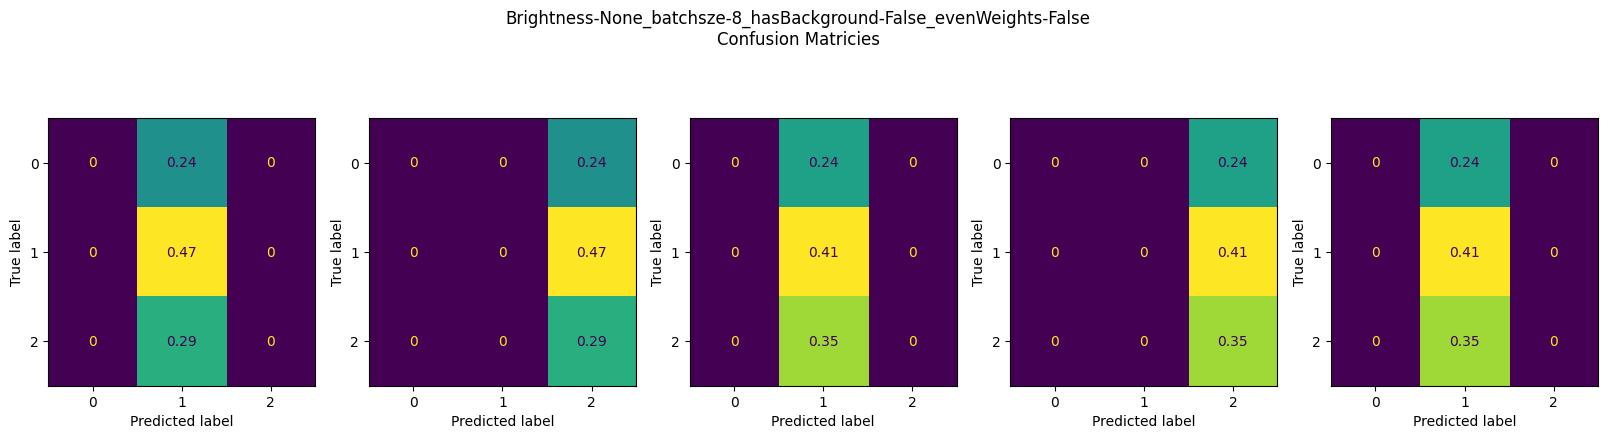

<Figure size 640x480 with 0 Axes>

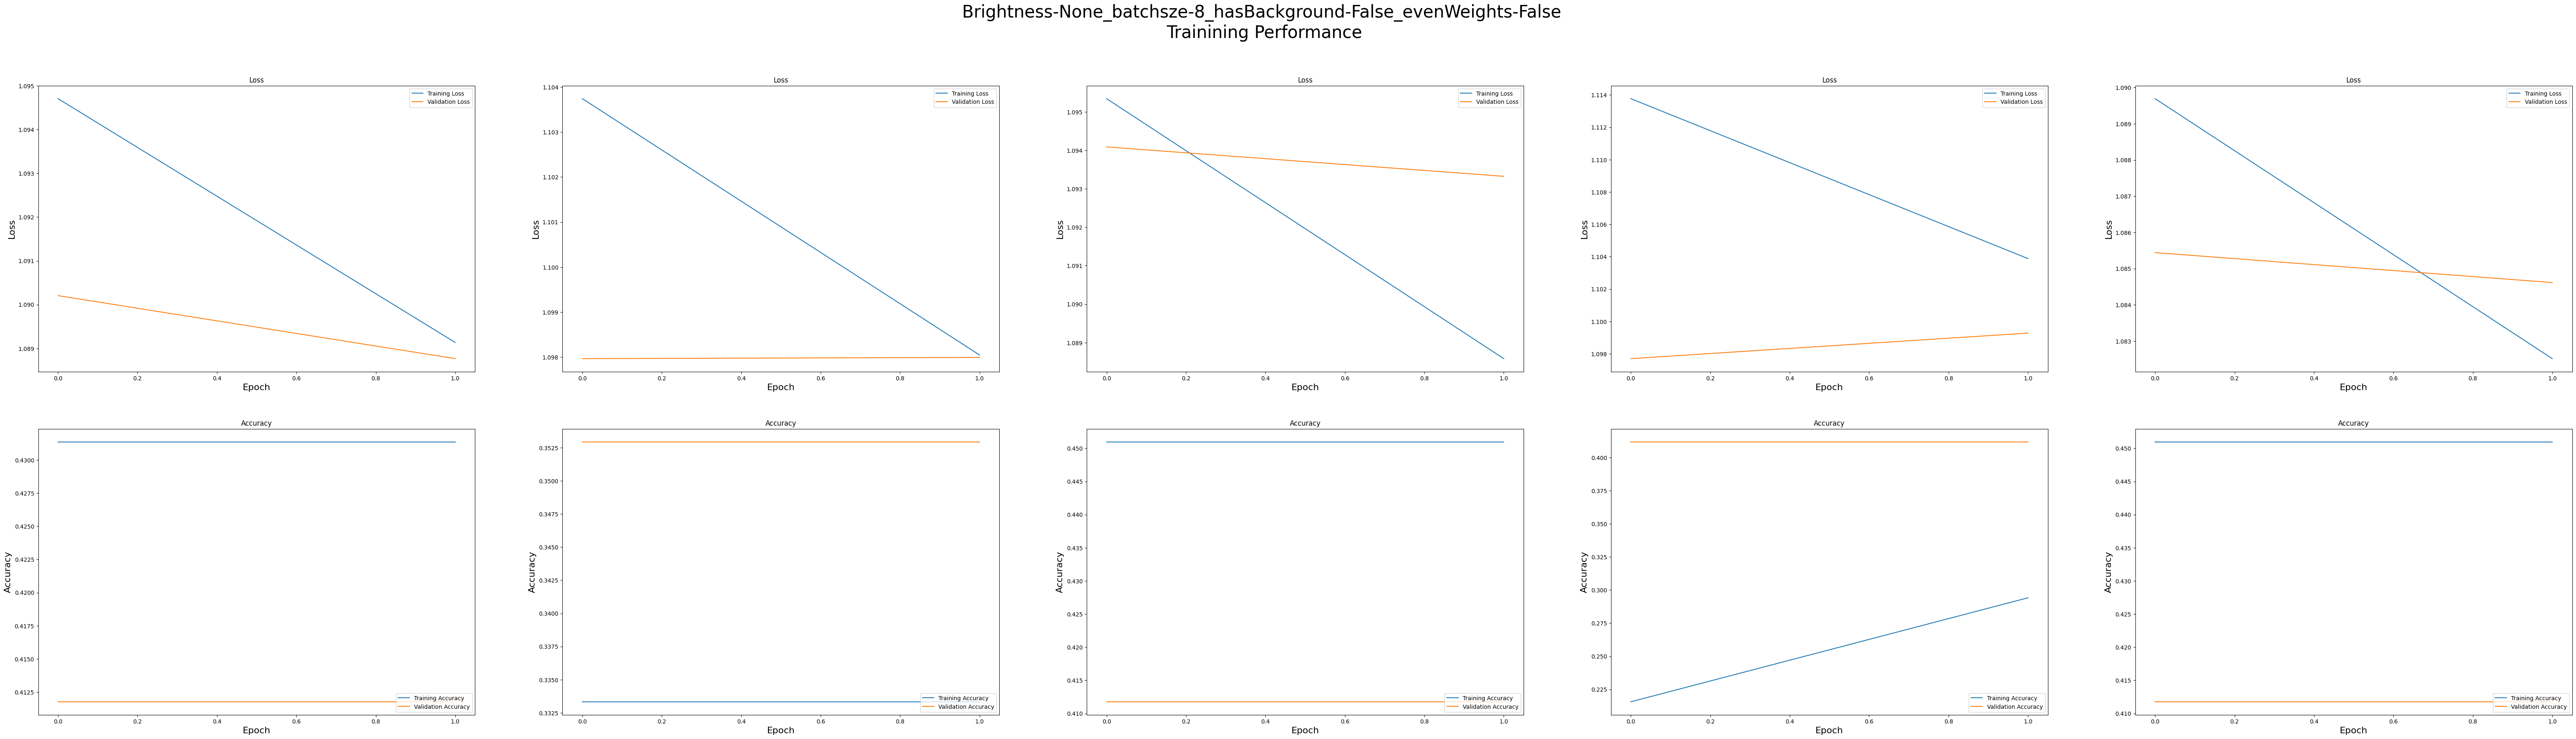

<Figure size 640x480 with 0 Axes>

In [ ]:
# Data augmentations

from sklearn.model_selection import StratifiedKFold

BATCHSIZE = 8
NUM_EPOCHS = 100

learningRate = 0.0001
hasBackground = True

# Balance the classes used in the model
class1Percentage = (0.3333/16)
class2Percentage = (0.3333/30)
class3Percentage = (0.3333/24)

weightsForClasses = [class1Percentage / (class1Percentage+class2Percentage+class3Percentage) , class3Percentage / (class1Percentage+class2Percentage+class3Percentage), class3Percentage / (class1Percentage+class2Percentage+class3Percentage)]

#Make all transforms that I am going to test:
transformsTested = {
    "0%":generateTransform(RandomRotationValue=0, RandomElaticTransform=[0.01,0.01], brightnessConstant=0, contrastConstant=0.0, kernelSize=3, sigmaRange=(0.001,0.002)),
    "20%":generateTransform(RandomRotationValue=20, RandomElaticTransform=[0.2,0.2], brightnessConstant=0.2, contrastConstant=0.2, kernelSize=3, sigmaRange=(0.001,0.2)),
    "40%":generateTransform(RandomRotationValue=40, RandomElaticTransform=[0.40,0.40], brightnessConstant=0.4, contrastConstant=0.40, kernelSize=3, sigmaRange=(0.2,0.4)),
    "60%":generateTransform(RandomRotationValue=60, RandomElaticTransform=[0.60,0.60], brightnessConstant=0.6, contrastConstant=0.6, kernelSize=3, sigmaRange=(0.4,0.6)),
    "80%":generateTransform(RandomRotationValue=80, RandomElaticTransform=[0.8,0.8], brightnessConstant=0.8, contrastConstant=0.8, kernelSize=3, sigmaRange=(0.6,0.8)),
    "100%":generateTransform(RandomRotationValue=100, RandomElaticTransform=[1.0,1.0], brightnessConstant=1.0, contrastConstant=1.0, kernelSize=3, sigmaRange=(0.8,1.0)),
    
}

# Run the tests
for key, value in transformsTested.items():
    generateKFoldsValidation(key,"-", k=5,trainingTransform=value, learningRate = learningRate, batchSize=BATCHSIZE, numberOfEpochs=NUM_EPOCHS)